# Demo of Model pipeline
1. Find images with similar global descriptors
2. Cluster by covisiblity (optional)
3. Find local descriptors
4. Match to SfM model
5. Calculate pose

## Setup: Imports, Loading data
Loading data into memory. This may take some minutes.

In [1]:
import os
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torchvision import transforms
import cv2
import time
from collections import namedtuple
import sqlite3
#import read_model as rm
import nearpy
import threading
from pyquaternion import Quaternion
import transforms3d.quaternions as txq
import matplotlib.colors as mcolors
from argparse import Namespace

from dataset_loaders.txt_to_db import get_images, get_points
from dataset_loaders.utils import load_image
from dataset_loaders.pose_utils import quaternion_angular_error
import models.netvlad_vd16_pitts30k_conv5_3_max_dag as netvlad
import models.demo_superpoint as superpoint
import models.super_point_pytorch as superpoint_new
from evaluate import *
import common.feature_matching as matching
from models.cirtorch_network import init_network, extract_vectors

np.random.seed(0)

#%matplotlib inline
#%load_ext autoreload
#%autoreload 2
%matplotlib widget

In [2]:
## settings
global_method = 'Cirtorch'
if global_method == 'NetVLAD':
    global_resolution = 224  #alternative: 256
elif global_method == 'Cirtorch':
    global_resolution = 1024
n_images = 20
augmented = False
clustering = False

In [3]:
t = time.time()
if 'images' not in locals():
    images = get_images()
if 'points3d' not in locals():
    points3d = get_points()
t = time.time() - t
print('Loaded data in {:.2f} seconds'.format(t))
get_img_normal = lambda i: np.array(load_image('data/AachenDayNight/images_upright/{}'.format(images[i].name)))
get_img_augmented = lambda i: load_image(os.path.join('data/AachenDayNight/AugmentedNightImages_v2',os.path.split(images[i].name)[-1]).replace('.jpg', '.png'))
get_img = lambda i: get_img_normal(i) if i >= 0 else get_img_augmented(-i)
database_cursor = get_cursor('data/AachenDayNight/aachen.db')
query_cursor = get_cursor('data/queries.db')
kpt_size = 1.
##create image clusters
if clustering:
    t = time.time()
    img_cluster = get_img_cluster(images, points3d)
    t = time.time() - t
    print('Found %d cluster in %d s'%(len(img_cluster), t))
# Camera matrix
camera_matrices = get_camera_matrices()

Loaded data in 36.37 seconds


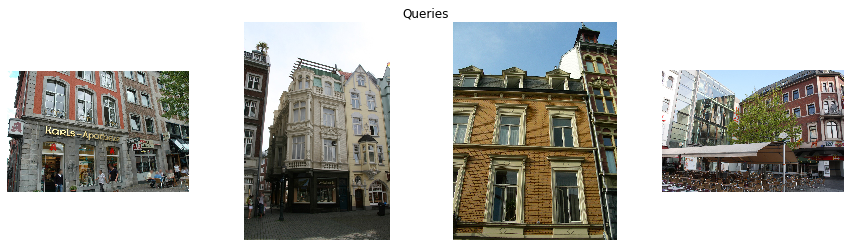

In [4]:
"""
2 random day time queries
2 random night time queries
8 dataset queries
 - 4 randomly selected
 - 4 hard cases
"""
standard_queries = [1, 2500, 4000, 2849]
#hard_examples = [2699, 2976, 294, 2907, 2435, 2705, 2670, 3061, 2675, 2672, 3239, 2566,2322,2673,2678, 2053, 3784]
#dataset_queries += hard_examples
no_global = [2907, 3239, 2786, 3786, 3500, 3970, 3966, 4083]
few_inliers = [2976, 294, 2435, 2675, 2678, 1246, 3784, 2048, 3788, 3790, 3839, 3849, 382, 2874, 258, 634, 3054, 3055, 160, 162, 421, 1236, 559, 2426, 2428, 557, 3474, 371, 2066, 3938, 223, 3445, 615, 2606, 572, 2593, 4043, 2300]
other = [2699,  2705,  3061,  2672,  2566,  2673,  2053,  3791,  2885,  1930,  1228,  2325,  2580,  1401,  4050,  4051,  4048]
other_no_refilter = [2699,  2705,  2670,  2322,  2885,  3802,  4032,  4026,  421,  1228,  2504,  2580,  572,  4050,  4051,  4048,  1926]
augmented_queries = []# [1, 500, 250]
interesting = [3134]
dataset_queries = standard_queries
path_to_queries = [
                   'data/AachenDayNight/images_upright/query/day/nexus5x/IMG_20161227_162905.jpg',
                   'data/AachenDayNight/images_upright/query/day/nexus5x/IMG_20161227_160713.jpg',
                   'data/AachenDayNight/images_upright/query/night/nexus5x/IMG_20161227_172616.jpg',
                   'data/AachenDayNight/images_upright/query/night/nexus5x/IMG_20161227_191152.jpg',
                   #'data/AachenDayNight/images_upright/db/1.jpg',
                   #'data/AachenDayNight/images_upright/db/500.jpg'
                  ] 
path_to_queries = []
num_query_images = len(path_to_queries)
path_to_queries = path_to_queries + ['data/AachenDayNight/images_upright/db/'+str(i)+'.jpg' for i in dataset_queries] 
path_to_queries = path_to_queries + ['data/AachenDayNight/AugmentedNightImages_high_res/'+str(i)+'.png' for i in augmented_queries]
n_queries = len(path_to_queries)
low_res_transform = transforms.Compose([transforms.Resize(global_resolution), transforms.CenterCrop(global_resolution)])
query_imgs_high_res = [load_image(path) for path in path_to_queries]
#query_imgs_low_res = [transform(img) for img in query_imgs_high_res]
fig = plt.figure(figsize=(15,4))
plt.title('Queries')
plt.axis('off')
for i, img in enumerate(query_imgs_high_res):
    a = fig.add_subplot(1, len(query_imgs_high_res), i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## 1. Find similar images (global descriptors)

In [5]:
if global_method == 'NetVLAD':
    model = netvlad.vd16_pitts30k_conv5_3_max_dag(weights_path='data/teacher_models/netvlad_pytorch/vd16_pitts30k_conv5_3_max_dag.pth')
    model.eval()
    query_global_desc = [model(transforms.ToTensor()(low_res_transform(img)).unsqueeze(0)).detach().cpu().squeeze(0).numpy() for img in query_imgs_high_res]
    query_global_desc = np.vstack(query_global_desc)
elif global_method == 'Cirtorch':
    state = torch.load('data/teacher_models/retrievalSfM120k-resnet101-gem-b80fb85.pth')   
    net_params = {}
    net_params['architecture'] = state['meta']['architecture']
    net_params['pooling'] = state['meta']['pooling']
    net_params['local_whitening'] = state['meta'].get('local_whitening', False)
    net_params['regional'] = state['meta'].get('regional', False)
    net_params['whitening'] = state['meta'].get('whitening', False)
    net_params['mean'] = state['meta']['mean']
    net_params['std'] = state['meta']['std']
    net_params['pretrained'] = False
    # load network
    net = init_network(net_params)
    net.load_state_dict(state['state_dict'])
    if 'Lw' in state['meta']:
        net.meta['Lw'] = state['meta']['Lw']
    ms = list(eval('[1]'))
    if len(ms)>1 and net.meta['pooling'] == 'gem' and not net.meta['regional'] and not net.meta['whitening']:
        msp = net.pool.p.item()
        print(">> Set-up multiscale:")
        print(">>>> ms: {}".format(ms))            
        print(">>>> msp: {}".format(msp))
    else:
        msp = 1
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    # set up the transform
    normalize = transforms.Normalize(
        mean=net.meta['mean'],
        std=net.meta['std']
    )
    transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    Lw = None
    query_global_desc = extract_vectors(net, path_to_queries, global_resolution, transform, ms=ms, msp=msp)
    query_global_desc = query_global_desc.numpy().T
print('{} query descriptors with {} dimensions'.format(*query_global_desc.shape))

>>>> 4/4 done...
4 query descriptors with 2048 dimensions


Global descriptors for dataset are precalculated

In [6]:
print('Loading database global features')
t = time.time()
if global_method == 'NetVLAD':
    if augmented:
        global_features_cursor = get_cursor('data/global_features_augmented.db')
    else:
        global_features_cursor = get_cursor('data/global_features_low_res.db')

    global_features = []
    image_ids = []
    for row in global_features_cursor.execute('SELECT image_id, cols, data FROM global_features;'):
        global_features.append(np.frombuffer(row[2], dtype=np.float32).reshape(-1, row[1]))
        image_ids.append(row[0])
    if augmented:    
        for row in global_features_cursor.execute('SELECT image_id, cols, data FROM global_augmented_features;'):
            global_features.append(np.frombuffer(row[2], dtype=np.float32).reshape(-1, row[1]))
            image_ids.append(-row[0])

    global_features = np.vstack(global_features)
    global_features_cursor.close()
elif global_method == 'Cirtorch':
    global_features = np.load('data/cirtorch_data_descs.npy').T
    image_ids = [images[i].id for i in images]
    if augmented:
        aug_features = np.load('data/cirtorch_augmented_descs.npy').T
        global_features = np.concatenate([global_features, aug_features])
        image_ids += [-images[i].id for i in images]
print('{} dataset descriptors with {} dimensions'.format(*global_features.shape))
t = time.time() - t
print('%d seconds'%t)

Loading database global features
4328 dataset descriptors with 2048 dimensions
0 seconds


In [7]:
global_neighbor_method = 'approx_cpu' #choices=['LSH', 'exact', 'approx']
global_matcher = matching.GlobalMatcher(global_neighbor_method, n_images+2 if augmented else n_images+1)

In [8]:
indices = global_matcher.match(query_global_desc, global_features)

In [9]:
## Discard direct neighbors of dataset images (i.e. themselves)
indices_cut = []
for i in range(num_query_images):
    indices_cut.append(indices[i,:n_images])
for i in range(num_query_images, len(path_to_queries)):
    #indices_cut.append(indices[i,1:n_images+1])
    lst = []
    j = 0
    img_itself = abs(image_ids[indices[i,0]])
    for idx in indices[i,1:]:
        #aug = image_ids[idx] < 0
        #ixs = -image_ids[idx] if aug else image_ids[idx]
        if abs(image_ids[idx]) != img_itself:
            lst.append(idx)
            j += 1
        if j >= n_images:
            break
    indices_cut.append(lst)
    #print(len(lst))
indices = np.stack(indices_cut)
print(indices.shape)

(4, 20)


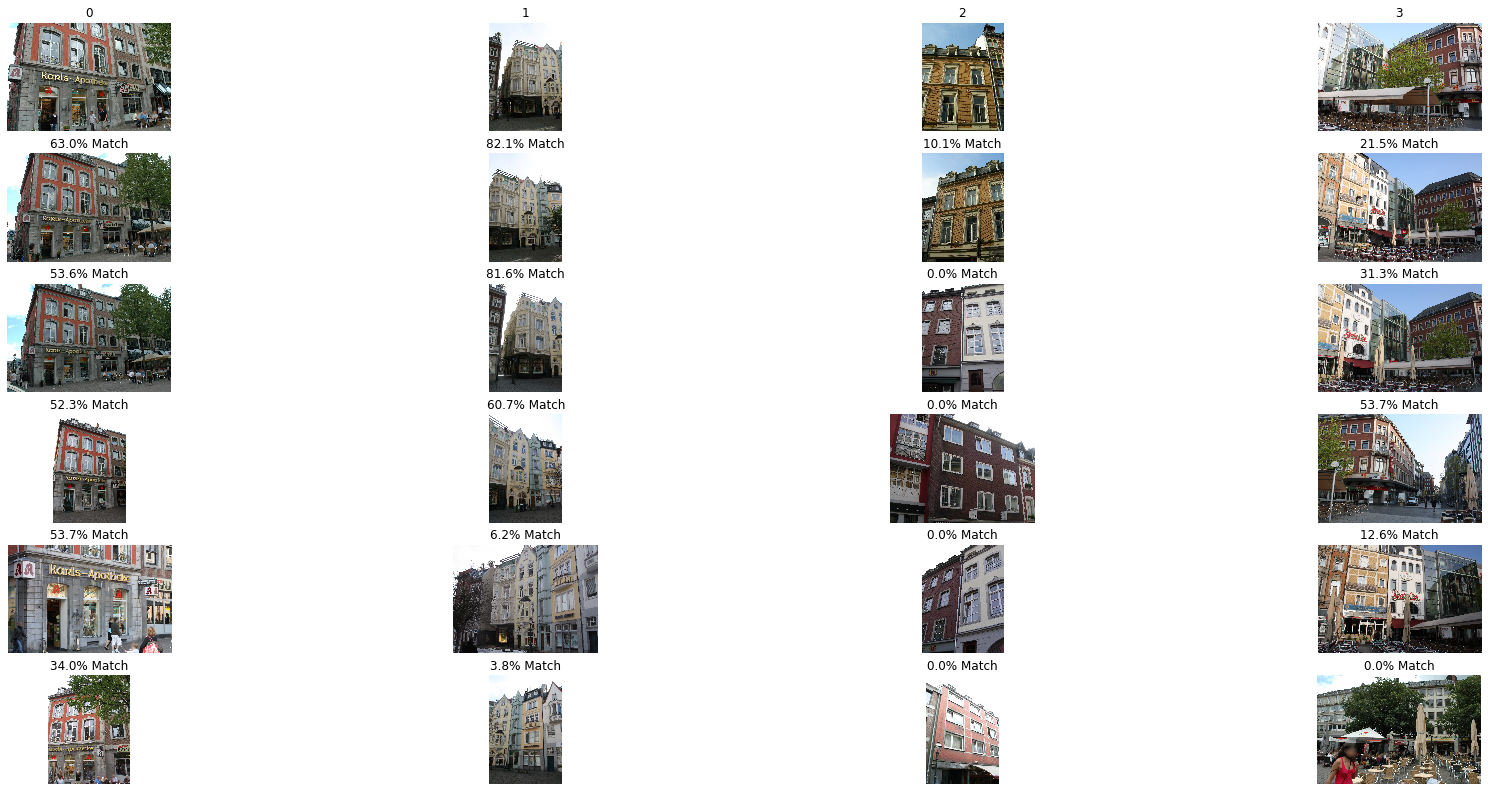

In [10]:

max_n = min(5, n_images)

fig = plt.figure(figsize=(30,50))
for i, query_img in enumerate(query_imgs_high_res):
    imgs = [query_img] 
    for n, j in enumerate(indices[i]):
        if n < max_n:
            if j > len(images):
                imgs = imgs + [get_img_augmented(-image_ids[j])]
            else:
                imgs = imgs + [get_img(image_ids[j])]
    #plt.title('Neighbors')
    img_name = 'db/'+path_to_queries[i].split('/')[-1].replace('.png', '.jpg')
    for j, img in enumerate(imgs):
        # use this to transpose figure
        ax = fig.add_subplot(n_images+1, n_queries, j*len(query_imgs_high_res)+i+1)
        #ax = fig.add_subplot(n_queries, max_n+1, i*(max_n+1)+j+1)
        ax.imshow(img)
        if i >= num_query_images and j > 0:
            #if augmented:
            #    pass
            #else:
            ax.set_title('{:.1f}% Match'.format(calc_neighbor_match(get_img_id(database_cursor, img_name), abs(image_ids[indices[i,j-1]]), images)))
        #    plt.title('Neighbor')#'%.0f'%distances[i][j-1])
        elif j == 0:
            ax.set_title(i)
        ax.axis('off')
#fig.savefig('figures/global_neighbor_fails.png', bbox_inches="tight")
plt.show()

In [11]:
first_good_neighbor = []
n_good_neighbors = []
for query_id in range(num_query_images, len(query_imgs_high_res)):
    query_db_id = get_img_id(database_cursor, 'db/'+path_to_queries[query_id].split('/')[-1].replace('.png', '.jpg'))
    found = False
    n, k = 0, 0
    for i, idx in enumerate(indices[query_id]):
        m = calc_neighbor_match(query_db_id, abs(image_ids[idx]), images)
        #print(m)
        if m > 0.0:
            if not found:
                first_good_neighbor.append(i)
                k = i
            n += 1
            #plt.imshow(get_img(image_ids[idx]))
            #plt.show()
            found = True
    print('id: {}\tk: {}\tn: {}'.format(query_id, k, n))
    n_good_neighbors.append(n)
            
    if not found:
        first_good_neighbor.append(-1)
        print('id: {}\tNo match found in {} neighbors'.format(query_id, n_images))
        
print(first_good_neighbor)
print(n_good_neighbors)

id: 0	k: 0	n: 16
id: 1	k: 0	n: 7
id: 2	k: 0	n: 3
id: 3	k: 0	n: 7
[0, 0, 0, 0]
[16, 7, 3, 7]


In [12]:
t = time.time()
#indices_global = __approx_np_global__(global_features[:global_features.shape[0]//2] if augmented else global_features, global_features,global_features.shape[0]//2-1 if augmented else global_features.shape[0]-1)  # cpu version
#indices_global = __approx_torch_global__(global_features[:global_features.shape[0]//2] if augmented else global_features, global_features,global_features.shape[0]//2 if augmented else global_features.shape[0])# gpu version
global_matcher = matching.GlobalMatcher(global_neighbor_method, global_features.shape[0]//2-1 if augmented else global_features.shape[0]-1)
indices_global = global_matcher.match(global_features[:global_features.shape[0]//2] if augmented else global_features, global_features)
t = time.time() - t
print('{}'.format(time_to_str(t)))

2.5 seconds


In [13]:
t = time.time()
nb_lookup = {}
for i, nbs in enumerate(indices_global):
    k = 1
    while k < nbs.shape[0] and calc_neighbor_match(image_ids[i], abs(image_ids[nbs[k]]), images) <= 1.0:
        k += 1
    #print('id: {}\tk: {}\t Match: {:.1f}'.format(i, k, calc_neighbor_match(image_ids[i], image_ids[indices[i,k]])))
    nb_lookup[i] = k
t = time.time() - t
print('{:.1f} seconds'.format(t))

2.8 seconds


In [14]:
vals = np.array(list(nb_lookup.values()))

In [15]:
def get_incorrect(vals, k):
    return vals[vals > k].shape[0]
def get_correct(vals, k):
    return vals[vals <= k].shape[0]/vals.shape[0]
k = 20
wrong = get_incorrect(vals, k)
print('{}/{} ({:.2f}%) have incorrect global neighbor for k={}'.format(wrong, vals.shape[0], 100.0*(wrong/vals.shape[0]), k))


9/4328 (0.21%) have incorrect global neighbor for k=20


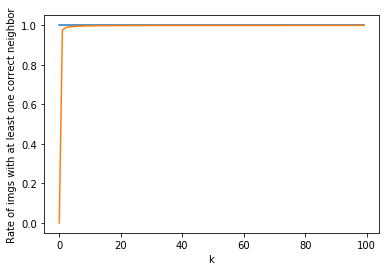

In [16]:
x = np.arange(100)
plt.plot(x, np.ones_like(x))
plt.plot(x, [get_correct(vals, i) for i in x])
plt.xlabel('k')
plt.ylabel('Rate of imgs with at least one correct neighbor')
plt.savefig('figures/global_matching_rate.png')
plt.show()

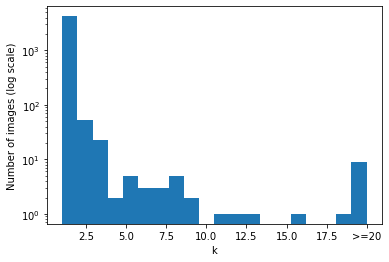

In [17]:
vals_hist = vals.copy()
cut_value = 20
vals_hist[vals_hist > cut_value] = cut_value
fig, ax = plt.subplots()
ax.hist(vals_hist, bins=cut_value, log=True)
ax.set_ylabel('Number of images (log scale)')
ax.set_xlabel('k')
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-2] = '>={}'.format(cut_value)
ax.set_xticklabels(labels)
fig.savefig('figures/k_hist.png')


## 2. Covisibility clustering

In [18]:
query_id = 0
print('Query {}/{}'.format(query_id+1, len(query_imgs_high_res)))

Query 1/4


In [19]:
cluster_query = [[image_ids[indices[query_id][i]] for i in range(n_images)]] ## augmentation currently not supported for local matching
cluster_orig_ids = [image_ids[indices[query_id][0]]]

In [20]:
if clustering:
    cluster_query = [img_cluster[image_ids[indices[query_id][0]]]]
    cluster_orig_ids = [image_ids[indices[query_id][0]]]
    for i, ind in enumerate(indices[query_id]):
        ind = image_ids[ind]
        if i == 0:
            continue
        point_set = img_cluster[ind]
        print('Match neighbor %d'%i)
        disjoint = False
        for j, c in enumerate(cluster_query):
            if ind in c:
                print('  - Can be matched to cluster')
                #print(point_set - (point_set-cluster))
                cluster_query[j] |= point_set
                disjoint = True
                break
        if not disjoint:
            print('  - New cluster created')
            cluster_orig_ids.append(ind)
            cluster_query.append(point_set)

In [21]:
print('{} images in all cluster'.format(sum([len(i) for i in cluster_query])))
print('Global neighbor ids: {}'.format([i for j in cluster_query for i in j]))

20 images in all cluster
Global neighbor ids: [1112, 2223, 3969, 1068, 585, 1564, 3971, 1412, 3915, 1563, 1136, 587, 1114, 2960, 1562, 3334, 642, 2952, 3932, 3968]


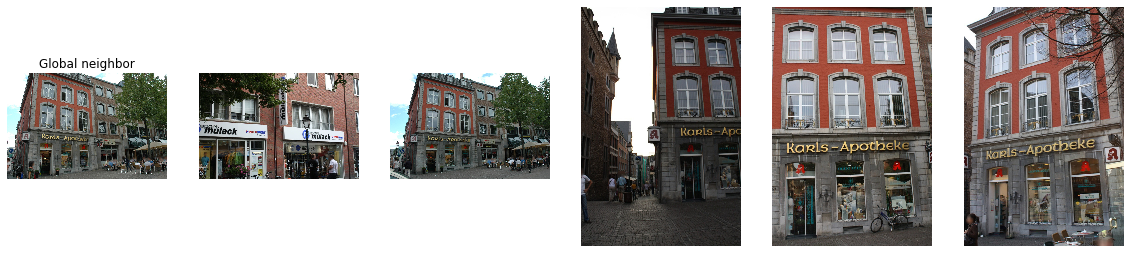

In [22]:
num_imgs_per_cluster = 5
num_imgs_per_cluster = min(num_imgs_per_cluster, n_images)
fig = plt.figure(figsize=(20,5))
#plt.title('Covisibility clustering')
#plt.axis('off')
for i, cluster in enumerate(cluster_query):
    imgs = list(cluster)
    sh = np.arange(len(imgs))
    np.random.shuffle(sh)
    sh = sh[:num_imgs_per_cluster]
    imgs = np.array(imgs)[sh]
    imgs = [get_img(cluster_orig_ids[i])]+[get_img(j) for j in imgs]
    for j, img in enumerate(imgs):
        a = fig.add_subplot(len(cluster_query), len(imgs), i*len(imgs)+j+1)
        a.imshow(img)
        a.axis('off')
        if j == 0:
            plt.title('Global neighbor')
#fig.savefig('figures/cluster.png', bbox_inches="tight")
plt.show()

Create scatter plot of 3d points in images
18682	points in cluster
Median is [ 724.9        2.24873 -209.062  ]


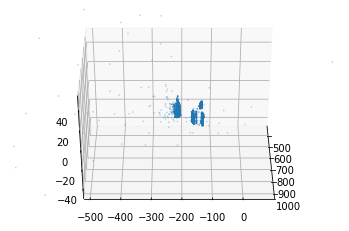

In [23]:
print('Create scatter plot of 3d points in images')
cluster_points = []
for i, c in enumerate(cluster_query):
    imgs_cluster = list(c)
    points_cluster = set()
    for ind in imgs_cluster:
        pt_ids = images[abs(ind)].point3D_ids
        valid = pt_ids > 0
        points_cluster |= set(pt_ids[valid])
    points_cluster = list(points_cluster)
    cluster_points.append(np.stack([points3d[x].xyz for x in points_cluster]))
    """mask = np.ones(len(points3d),dtype=bool) #np.ones_like(a,dtype=bool)
    mask[points_cluster] = False

    cluster_points.append(points3d[~mask])"""
    print('%d\tpoints in cluster'%cluster_points[i].shape[0])
#other_points = points[mask]
#print('%d other points'%other_points.shape[0])
thresh = 300
ax = plt.axes(projection='3d')
#ax.scatter3D(other_points[:,0], other_points[:,2], other_points[:,1], s = 0.5, alpha = 0.01)
for cp in cluster_points:
    ax.scatter3D(cp[:,0], cp[:,2], cp[:,1], s = 0.5, alpha = 0.25)
median = np.sum([np.median(cp, axis=0)*cp.shape[0] for cp in cluster_points], axis=0)/float(sum([cp.shape[0] for cp in cluster_points]))
print('Median is %s'%median)
ax.set_xlim3d(median[0]-thresh,median[0]+thresh)#min(sift_points[:,0]),min(sift_points[:,0])+max_dist)
ax.set_ylim3d(median[2]-thresh,median[2]+thresh)#min(sift_points[:,1]),min(sift_points[:,1])+max_dist)
ax.set_zlim3d(median[1]-50, median[1]+50)#min(sift_points[:,2]),min(sift_points[:,2])+max_dist)
ax.view_init(elev=35., azim=0)
#plt.savefig('figures/cluster_3d.png', bbox_inches="tight")
plt.show()

(5648, 3)
[3.31949853 7.5562607  7.49824482]
1.9836957667023343
(3,)
(5648,)
(3246, 3)


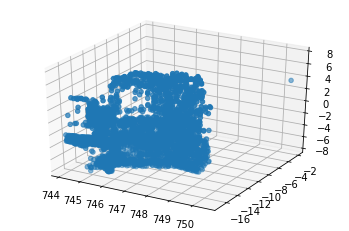

In [29]:
within_std = 1.0
img_idx = 12

valid = images[img_idx].point3D_ids > 0
pt_ids = images[img_idx].point3D_ids[valid]
pts = np.stack([points3d[i].xyz for i in pt_ids])
print(pts.shape)
mean, std = np.mean(pts, axis=0), np.std(pts, axis=0)
print(std)
print(np.std(std))
print(mean.shape)
if within_std > 0:
    valid_pts = np.all(np.abs(pts - mean) < within_std*std, axis=1)
    print(valid_pts.shape)
    pts = pts[valid_pts]
print(pts.shape)
ax = plt.axes(projection='3d')
ax.scatter3D(pts[:,0], pts[:,2], pts[:,1])
plt.show()

## 3. Find local descriptors

<b> Order to get image - keypoint - 3D point correspondances: </b>
1. take image
2. find image name
3. find db_id of image_name
4. get keypoints
5. get valid 3d points

In [24]:
nn = first_good_neighbor[query_id-num_query_images]
test_id = cluster_query[0][nn] if nn >= 0 else cluster_orig_ids[0]
#test_id = cluster_orig_ids[0] #197

db/1.jpg


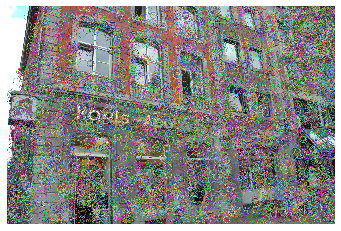

In [25]:
if query_id < num_query_images:
    test_query_path = path_to_queries[query_id].replace('data/AachenDayNight/images_upright/query/', '')
    print(test_query_path)
    query_img_id = get_img_id(query_cursor, test_query_path)
    query_kpts, query_desc_colmap = get_kpts_desc(query_cursor, query_img_id)
else:
    fake_query_path = 'db/'+path_to_queries[query_id].split('/')[-1].replace('.png','.jpg')
    print(fake_query_path)
    query_img_id = get_img_id(database_cursor,fake_query_path)
    query_kpts, query_desc_colmap = get_kpts_desc(database_cursor, query_img_id)
    
query_kpts_colmap = kpts_to_cv(query_kpts, kpt_size=30.0)
query_img = cv2.drawKeypoints(np.array(query_imgs_high_res[query_id]),query_kpts_colmap, None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(query_img)
plt.axis('off')
plt.show()

db/2.jpg
len kpts: 3032


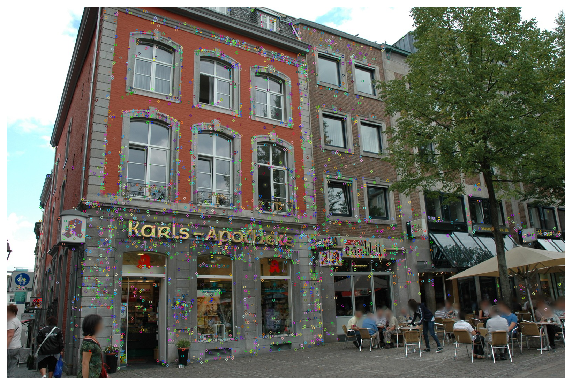

In [26]:
db_id = [i for j in cluster_query for i in j][first_good_neighbor[query_id]] #cluster_orig_ids[0]
img_name = images[abs(db_id)].name
if db_id >= 0:
    neighbor_img_original_path = 'data/AachenDayNight/images_upright/'+img_name
elif db_id <= 0:
    neighbor_img_original_path = 'data/AachenDayNight/AugmentedNightImages_high_res/'+os.path.split(img_name)[-1].replace('.jpg', '.png')
neighbor_img_original = np.array(load_image(neighbor_img_original_path))
print(img_name)
valid = images[abs(db_id)].point3D_ids > 0 
#print([i for i in range(len(valid)) if valid[i]])
neighbor_kpts, neighbor_desc_colmap = get_kpts_desc(database_cursor, abs(db_id))
neighbor_kpts = neighbor_kpts[valid[:neighbor_kpts.shape[0]]] - 0.5
neighbor_kpts_cv = kpts_to_cv(neighbor_kpts, kpt_size=100.)
pt_ids = images[abs(db_id)].point3D_ids[valid]
print('len kpts: %d'%len(neighbor_kpts_cv))
plt.figure(figsize=(10,10))
neighbor_img = cv2.drawKeypoints(neighbor_img_original,neighbor_kpts_cv, None)
plt.imshow(neighbor_img)
plt.axis('off')
plt.show()
neighbor_desc_colmap = neighbor_desc_colmap[valid[:neighbor_desc_colmap.shape[0]]]
#print(images[db_id])
#print(pt_ids.shape)
#print(len(neighbor_kpts_cv))
#print(len(valid)//2)
#print(neighbor_desc_colmap.shape)
#print(neighbor_img_original.shape)

In [27]:
my_config = False
if my_config:
    extractor = superpoint.SuperPointFrontend(weights_path='data/teacher_models/superpoint_v1.pth',
                          nms_dist=4, conf_thresh=0.015, nn_thresh=.7, cuda=torch.cuda.is_available())
else:
    config = {
                'nms_radius': 0,
                'detector_threshold': 0,
                'num_keypoints': 2000,
                'border_remove': 4,
            }
    extractor = superpoint_new.SuperPointFrontend(config, weights_path='data/teacher_models/superpoint_v1.pth')

(1063, 1600)


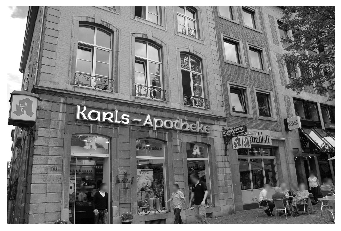

In [28]:
#def rgb2gray(rgb):
#    rgb = np.dot(rgb[...,:3], [0.299, 0.587, 0.144]).astype(np.float32) 
#    return rgb / rgb.max()
#example_grayscale = rgb2gray(np.array(query_imgs_high_res[query_id]))

#example_grayscale = cv2.imread(path_to_queries[query_id], 0).astype(np.float32)/255.0
query_img_original = np.array(query_imgs_high_res[query_id],dtype=np.float32)
example_grayscale = query_img_original[:, :, 0]/255.0
print(example_grayscale.shape)

plt.imshow(example_grayscale, cmap = plt.get_cmap('gray'))
plt.axis('off')
plt.show()

In [29]:
#torch.cuda.empty_cache()  
if my_config:
    pts, query_desc_superpoint, heatmap = extractor.run(example_grayscale)
    query_desc_superpoint = query_desc_superpoint.T
    pts = pts.T
else:
    ret = extractor.run(query_img_original)
    query_desc_superpoint = ret['local_descriptors']
    pts = ret['keypoints']
    print(pts.shape)
print(query_desc_superpoint.shape)

(2000, 2)
(2000, 256)


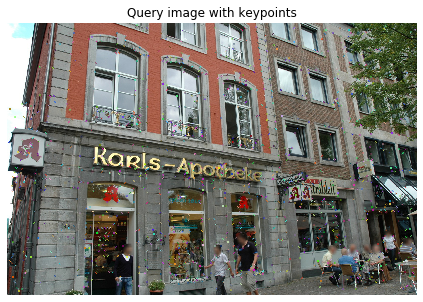

In [30]:
#print(pts.shape)  #3xN numpy array with corners [x_i, y_i, confidence_i]^T
#print(query_desc_superpoint.shape) #256xN numpy array of corresponding unit normalized descriptors.
#print(heatmap.shape)
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2 if my_config else 1, 1)
query_kpts_superpoint = kpts_to_cv(pts, kpt_size=50.0)
query_img = cv2.drawKeypoints(np.array(query_imgs_high_res[query_id]),query_kpts_superpoint, None)
plt.imshow(query_img)
a.set_title('Query image with keypoints')
plt.axis('off')
if my_config:
    a = fig.add_subplot(1, 2, 2)
    plt.imshow(heatmap)
    a.set_title('Heatmap')
    plt.axis('off')
    plt.show()

In [31]:
if my_config:
    neighbor_img_original_gs = cv2.imread(neighbor_img_original_path, 0).astype(np.float32)/255.0
    _, neighbor_desc_superpoint, heatmap = extractor.run(neighbor_img_original_gs, points=neighbor_kpts)
    neighbor_desc_superpoint = neighbor_desc_superpoint.T
else:
    ret_neighbor = extractor.run(neighbor_img_original.astype(np.float32)/255.0)
    desc_map = ret_neighbor['local_descriptor_map']
    k = (neighbor_kpts.copy()//8).astype(np.int)
    k = np.flip(k, axis=1)
    neighbor_desc_superpoint = desc_map[k[:,0],k[:,1]]
    
    

print('Superpoint descriptor has {} features with {} dimensions'.format(*neighbor_desc_superpoint.shape))    


Superpoint descriptor has 3032 features with 256 dimensions


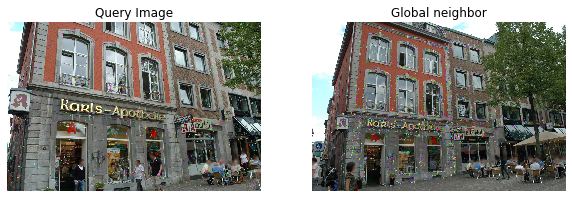

In [32]:
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2, 1)
plt.imshow(query_img)
plt.axis('off')
plt.title('Query Image')
a = fig.add_subplot(1,2,2)
plt.imshow(neighbor_img)
plt.axis('off')
plt.title('Global neighbor')
plt.show()

In [33]:
matching_type = 'approx' # choices = ['OpenCV', 'approx_torch', 'approx']
ratio_thresh = .75
local_matcher = matching.LocalMatcher(ratio_thresh, matching_type, False)
#local_matcher = matching.GlobalMatcher('approx', 1, False)

In [34]:
method = 'Superpoint'    # choices = ['colmap', 'superpoint']
if method == 'Colmap':
    query_desc = query_desc_colmap
    neighbor_desc = neighbor_desc_colmap
    query_kpts = query_kpts_colmap
elif method == 'Superpoint':
    query_desc = query_desc_superpoint
    neighbor_desc = neighbor_desc_superpoint
    query_kpts = query_kpts_superpoint
else:
    raise NotImplementedError('Method not implemented')



t = time.time()
print(query_desc.shape)
print(neighbor_desc.shape)
#"""
def double_matching(local_matcher, query_desc, neighbor_desc):
    matches_forward = local_matcher.match(query_desc, neighbor_desc)
    matches_reverse = local_matcher.match(neighbor_desc, query_desc)
    if matches_forward.shape[0] == 0 or matches_reverse.shape[0] == 0:
        return np.array([])
    #print(matches_forward.shape)
    #print(matches_reverse.shape)
    matches = []
    mr = list(matches_reverse[:,1])
    for m in matches_forward:
        if m[0] in mr:
            matches.append(m)
    matches = np.array(matches)
    return matches
#"""   
#matches = local_matcher.match(query_desc, neighbor_desc)
matches = double_matching(local_matcher, query_desc, neighbor_desc)
print(matches.shape)
matches_to_cv = lambda matches: [cv2.DMatch(_queryIdx=m[1], _trainIdx=m[0], _imgIdx=0, _distance=1.0) for m in matches]
#matches_to_cv = lambda matches: [cv2.DMatch(_queryIdx=i, _trainIdx=m[0], _imgIdx=0, _distance=1.0) for i, m in enumerate(matches)]
matches_cv = matches_to_cv(matches)
t = time.time() - t
print('Matching took {:.1f} seconds\nFound {} matches'.format(t, len(matches)))

(2000, 256)
(3032, 256)
(0,)
Matching took 0.3 seconds
Found 0 matches


1


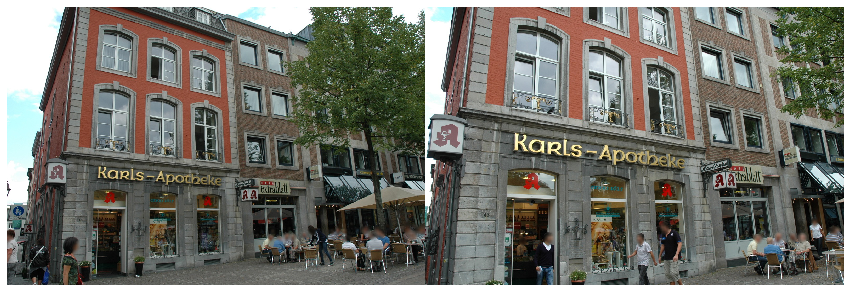

In [35]:
img3 = np.empty((max(query_img.shape[0], neighbor_img.shape[0]), query_img.shape[1] + neighbor_img.shape[1], 3), dtype=np.uint8)
cv2.drawMatches(neighbor_img_original,neighbor_kpts_cv,np.array(query_imgs_high_res[query_id]),query_kpts,matches_cv,outImg=img3,matchColor=None, singlePointColor=(255, 255, 255), flags=2)# **draw_params)
plt.figure(figsize=(15,15))
plt.imshow(img3)
plt.axis('off')
if query_id >= num_query_images:
    print(dataset_queries[query_id - num_query_images])
    #plt.savefig('figures/few_inlier_matching_{}.png'.format(dataset_queries[query_id - num_query_images]), bbox_inches="tight")
    #plt.savefig('figures/local_matching_{}_{}_{}.png'.format(matching_type, method, dataset_queries[query_id - num_query_images]), bbox_inches="tight")
plt.show()

In [ ]:
if method == 'Colmap' and query_id >= num_query_images:
    oimg = images[get_img_id(database_cursor, 'db/'+path_to_queries[query_id].split('/')[-1].replace('.png', '.jpg'))]
    nimg = images[image_ids[abs(indices[query_id,0])]]
    #print(oimg)
    #print(nimg)
    
    valid_o = oimg.point3D_ids > 0 
    pt_ids_o = oimg.point3D_ids#[valid_o]
    pt_ids_o = pt_ids_o[:pt_ids_o.shape[0]//2]

    valid_n = nimg.point3D_ids > 0 
    pt_ids_n = nimg.point3D_ids[valid_n]
    
    
    #print(pt_ids_o.shape)
    #print(pt_ids_n.shape)
    
    correct, incorrect = 0,0
    incorrect_matches = []
    for m1, m2 in matches:
        if valid_o[m1]:
            if pt_ids_o[m1] == pt_ids_n[m2]:
                correct += 1
            else:
                incorrect += 1
                incorrect_matches.append([m1, m2])
    incorrect_matches = matches_to_cv(np.array(incorrect_matches))
    print('{} correct / {} incorrect matches ({})'.format(correct, incorrect, '{:.1f}%'.format(100.0*(correct / float(correct+incorrect))) if (correct+incorrect)> 0 else 'fail'))
    img3 = np.empty((max(query_img.shape[0], neighbor_img.shape[0]), query_img.shape[1] + neighbor_img.shape[1], 3), dtype=np.uint8)
    cv2.drawMatches(neighbor_img_original,neighbor_kpts_cv,np.array(query_imgs_high_res[query_id]),query_kpts,incorrect_matches,outImg=img3,matchColor=None, singlePointColor=(255, 255, 255), flags=2)# **draw_params)
    plt.figure(figsize=(10,10))
    plt.title('Incorrectly matched')
    plt.imshow(img3)
    plt.axis('off')
    plt.show()

In [ ]:
args = Namespace(verify=None, local_method=method,augmentation=augmented)
print(args)
matched_pts_xyz, matched_keypoints, correct, incorrect = match_local(args, matching_type,
                                                                     query_desc, query_kpts,
                                                                     images, points3d, query_id,
                                                                     cluster_query, database_cursor,
                                                                     extractor,
                                                                     matching.LocalMatcher(ratio_thresh, matching_type, True),
                                                                     refilter=False, 
                                                                     double = True
                                                                    )

In [ ]:
print(matched_pts_xyz.shape)
print(matched_keypoints.shape)

## 5. Calculate pose

In [ ]:
query_path = path_to_queries[query_id].replace('data/AachenDayNight/images_upright/', '')
if 'Augmented' in query_path:
    query_path = query_path.replace('data/AachenDayNight/AugmentedNightImages_high_res/', 'db/').replace('.png', '.jpg')
cm = camera_matrices[query_path]
camera_matrix = cm['cameraMatrix']
distortion_coeff = cm['rad_dist']
print(camera_matrix)
print(distortion_coeff)

In [ ]:
n_iter = 5000

In [ ]:
if matched_pts_xyz.shape[0] < 4:
    print('No matches found')
    success = False
    inliers = []
else:
    t = time.time()
    dist_vec = np.array([distortion_coeff, 0, 0, 0])
    success, R_vec, translation, inliers = cv2.solvePnPRansac(
            matched_pts_xyz, matched_keypoints, camera_matrix, dist_vec,
            iterationsCount=n_iter, reprojectionError=8.,
            flags=cv2.SOLVEPNP_P3P)
    t = time.time() - t
    print('PnP RANSAC took %d seconds (%.2f/iteration)'%(t, float(t)/float(n_iter)))

In [ ]:
if success:
    print('Successful matching')
    print(inliers.shape)
    print(R_vec)
    print(translation)
else:
    print('Not succesful')


In [ ]:
print(matched_pts_xyz[inliers].shape)
print(matched_keypoints[inliers].shape)

In [ ]:
min_inliers = 5


if success:
    inliers = inliers[:, 0] if len(inliers.shape) > 1 else inliers
    num_inliers = len(inliers)
    inlier_ratio = len(inliers) / len(matched_keypoints)
    print('{} inliers ({:.1f}%)'.format(num_inliers, 100.0*inlier_ratio))
    success &= num_inliers >= min_inliers

    ret, R_vec, t = cv2.solvePnP(
                matched_pts_xyz[inliers], matched_keypoints[inliers], camera_matrix,
                dist_vec, rvec=R_vec, tvec=translation, useExtrinsicGuess=True,
                flags=cv2.SOLVEPNP_ITERATIVE)
    assert ret

    query_T_w = np.eye(4)
    query_T_w[:3, :3] = cv2.Rodrigues(R_vec)[0]
    query_T_w[:3, 3] = t[:, 0]
    w_T_query = np.linalg.inv(query_T_w)

    #ret = LocResult(success, num_inliers, inlier_ratio, w_T_query)
else:
    if inliers is None:
        num_inliers = 0
        inliers = []
    else:
        num_inliers = len(inliers) if type(inliers) is list else len(inliers[:,0])
print('Success') if success else print('Failed')

In [ ]:
inlier_pts_img = cv2.drawKeypoints(np.array(query_imgs_high_res[query_id]),[query_kpts[i] for i in inliers],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(15,15))
plt.imshow(inlier_pts_img)
plt.axis('off')
if query_id >= num_query_images:
    print('Save image {}'.format(dataset_queries[query_id - num_query_images]))
    #plt.savefig('figures/few_inliers_{}.png'.format(dataset_queries[query_id - num_query_images]))
plt.show()

In [ ]:
#print(w_T_query)
if success:
    print(w_T_query)
    qvec_nvm = list(Quaternion(matrix=query_T_w)) # rotmat2qvec(w_T_query[:3,:3])
    pos = -txq.rotate_vector(w_T_query[:3,3], qvec_nvm)
    print('Calculated position: {}\nOrientation: {}'.format(w_T_query[:3, 3], qvec_nvm))
    print('Transformed position: {}'.format(pos))
    if query_id >= num_query_images:
        #pose_stats_filename = os.path.join('data/AachenDayNight/', 'pose_stats.txt')
        #mean_t, std_t = np.loadtxt(pose_stats_filename)
        #position = dataset[dataset_queries[query_id-4]][1][:3]
        #position = position*std_t + mean_t
        position = colmap_image_to_pose(images[get_img_id(database_cursor, fake_query_path)])[:3,3]
        rotation = images[get_img_id(database_cursor, fake_query_path)].qvec

        #query_T_w = np.linalg.inv(result.T)
        #pos_nvm = query_T_w[:3, 3].tolist()

        error_rot = quaternion_angular_error(rotation, qvec_nvm)
        error = np.linalg.norm(position-w_T_query[:3,3])
        error_str = '%.1f m'%error if error > 1e-1 else '%.1f cm'%(100.0*error)
        print('Groundtruth: \t%s \nError transl.: \t%s\nAngular error: \t%.2f°'%(str(position), error_str, error_rot))
else:
    print('No success')